# Introduction
This notebook shows how to use TimesFM with finetuning. 

In order to perform finetuning, you need to create the Pytorch Dataset in a proper format. The example of the Dataset is provided below.
The finetuning code can be found in timesfm.finetuning_torch.py. This notebook just imports the methods from finetuning

### Dataset Creation

In [1]:
from os import path
from typing import Optional, Tuple

import joblib
import numpy as np
import pandas as pd
import torch
from finetuning.finetuning_torch import FinetuningConfig, TimesFMFinetuner
from huggingface_hub import snapshot_download
from torch.utils.data import Dataset

from timesfm import TimesFm, TimesFmCheckpoint, TimesFmHparams
from timesfm.pytorch_patched_decoder import PatchedTimeSeriesDecoder

from sklearn.preprocessing import MinMaxScaler

class TimeSeriesDataset(Dataset):
  """Dataset for time series data compatible with TimesFM."""

  def __init__(self,
               series: pd.DataFrame,
               context_length: int,
               horizon_length: int,
               freq_type: int = 0):
    """
        Initialize dataset.

        Args:
            series: Time series data
            context_length: Number of past timesteps to use as input
            horizon_length: Number of future timesteps to predict
            freq_type: Frequency type (0, 1, or 2)
        """
    if freq_type not in [0, 1, 2]:
      raise ValueError("freq_type must be 0, 1, or 2")

    self.series = series
    self.context_length = context_length
    self.horizon_length = horizon_length
    self.freq_type = freq_type
    self._prepare_samples()

  def _prepare_samples(self) -> None:
    """Prepare sliding window samples from the time series."""
    self.samples = []

    for trip_id, trip_data in self.series.groupby('unique_id'):
        trip_data = trip_data.sort_values('ds')[['y']]
        total_length = self.context_length + self.horizon_length

        for start_idx in range(0, len(trip_data) - total_length + 1):
          end_idx = start_idx + self.context_length
          x_context = trip_data.iloc[start_idx:end_idx]
          x_future = trip_data.iloc[end_idx:end_idx + self.horizon_length]
          self.samples.append((x_context, x_future))

  def __len__(self) -> int:
    return len(self.samples)

  def __getitem__(
      self, index: int
  ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    x_context, x_future = self.samples[index]

    x_context = torch.tensor(x_context.to_numpy(), dtype=torch.float32)
    x_future = torch.tensor(x_future.to_numpy(), dtype=torch.float32)

    input_padding = torch.zeros_like(x_context)
    freq = torch.tensor([self.freq_type], dtype=torch.long)

    return x_context, input_padding, freq, x_future

def prepare_datasets(series: pd.DataFrame,
                     context_length: int,
                     horizon_length: int,
                     freq_type: int = 2,
                     train_split: float = 0.8) -> Tuple[Dataset, Dataset]:
  """
    Prepare training and validation datasets from time series data.

    Args:
        series: Input time series data
        context_length: Number of past timesteps to use
        horizon_length: Number of future timesteps to predict
        freq_type: Frequency type (0, 1, or 2)
        train_split: Fraction of data to use for training

    Returns:
        Tuple of (train_dataset, val_dataset)
    """
  train_size = int(len(series) * train_split)
  train_data = series[:train_size]
  val_data = series[train_size:]

  # Create datasets with specified frequency type
  train_dataset = TimeSeriesDataset(train_data,
                                    context_length=context_length,
                                    horizon_length=horizon_length,
                                    freq_type=freq_type)

  val_dataset = TimeSeriesDataset(val_data,
                                  context_length=context_length,
                                  horizon_length=horizon_length,
                                  freq_type=freq_type)

  return train_dataset, val_dataset


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)].


### Model Creation

In [2]:
def get_model(load_weights: bool = False):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  repo_id = "google/timesfm-2.0-500m-pytorch"
  hparams = TimesFmHparams(
      backend=device,
      per_core_batch_size=32,
      horizon_len=20,
      num_layers=50,
      use_positional_embedding=False,
      context_len=
      128,  # Context length can be anything up to 2048 in multiples of 32
  )
  tfm = TimesFm(hparams=hparams,
                checkpoint=TimesFmCheckpoint(huggingface_repo_id=repo_id))

  model = PatchedTimeSeriesDecoder(tfm._model_config)
  if load_weights:
    checkpoint_path = path.join(snapshot_download(repo_id), "torch_model.ckpt")
    loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(loaded_checkpoint)
  return model, hparams, tfm._model_config


In [3]:
def plot_predictions(
    model: TimesFm,
    val_dataset: Dataset,
) -> None:
  """
    Plot model predictions against ground truth for a batch of validation data.

    Args:
      model: Trained TimesFM model
      val_dataset: Validation dataset
    """
  import matplotlib.pyplot as plt

  model.eval()

  x_context, x_padding, freq, x_future = val_dataset[0]
  x_context = x_context.unsqueeze(0)  # Add batch dimension
  x_padding = x_padding.unsqueeze(0)
  freq = freq.unsqueeze(0)
  x_future = x_future.unsqueeze(0)

  device = next(model.parameters()).device
  x_context = x_context.to(device)
  x_padding = x_padding.to(device)
  freq = freq.to(device)
  x_future = x_future.to(device)

  with torch.no_grad():
    predictions = model(x_context, x_padding.float(), freq)
    predictions_mean = predictions[..., 0]  # [B, N, horizon_len]
    last_patch_pred = predictions_mean[:, -1, :]  # [B, horizon_len]

  context_vals = x_context[0].cpu().numpy()
  future_vals = x_future[0].cpu().numpy()
  pred_vals = last_patch_pred[0].cpu().numpy()

  context_len = len(context_vals)
  horizon_len = len(future_vals)

  plt.figure(figsize=(12, 6))

  plt.plot(range(context_len),
           context_vals,
           label="Historical Data",
           color="blue",
           linewidth=2)

  plt.plot(
      range(context_len, context_len + horizon_len),
      future_vals,
      label="Ground Truth",
      color="green",
      linestyle="--",
      linewidth=2,
  )

  plt.plot(range(context_len, context_len + horizon_len),
           pred_vals,
           label="Prediction",
           color="red",
           linewidth=2)

  plt.xlabel("Time Step")
  plt.ylabel("Value")
  plt.title("TimesFM Predictions vs Ground Truth")
  plt.legend()
  plt.grid(True)
  plt.show()

In [4]:
def get_data(context_len: int,
             horizon_len: int,
             coord: str,
             freq_type: int = 2) -> Tuple[Dataset, Dataset, any]:
    df = pd.read_parquet("../../data/data_taxi_central_based.parquet")
    trip_ids_to_keep = [1398764351620000197, 1380694967620000451]
    df = df[df['TRIP_ID'].isin(trip_ids_to_keep)]

    coord_to_drop = 'LAT' if coord == 'LON' else 'LON'
    df = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', coord_to_drop])
    df = df.sort_values(by=['TRIP_ID', 'TIMESTAMP'])

    df = df.rename(columns={coord: 'y', 'TRIP_ID': 'unique_id', 'TIMESTAMP': 'ds'})

    scaler = MinMaxScaler()
    df['y'] = scaler.fit_transform(df[['y']])

    time_series = df
    print(time_series.shape)

    train_dataset, val_dataset = prepare_datasets(
        series=time_series,
        context_length=context_len,
        horizon_length=horizon_len,
        freq_type=freq_type,
        train_split=0.5,
    )

    print(f"Created datasets:")
    print(f"- Training samples: {len(train_dataset)}")
    print(f"- Validation samples: {len(val_dataset)}")
    print(f"- Using frequency type: {freq_type}")
    return train_dataset, val_dataset, scaler


def single_gpu_example(coord: str):
    """Basic example of finetuning TimesFM on stock data."""
    model, hparams, tfm_config = get_model(load_weights=True)
    config = FinetuningConfig(batch_size=256,
                              num_epochs=5,
                              learning_rate=1e-4,
                              use_wandb=False,
                              freq_type=2,
                              log_every_n_steps=10,
                              val_check_interval=0.5,
                              use_quantile_loss=True)

    train_dataset, val_dataset, scaler = get_data(128,
                                             tfm_config.horizon_len,
                                             coord,
                                             freq_type=config.freq_type)
    finetuner = TimesFMFinetuner(model, config)

    print("\nStarting finetuning...")
    results = finetuner.finetune(train_dataset=train_dataset,
                                 val_dataset=val_dataset)

    print("\nFinetuning completed!")
    print(f"Training history: {len(results['history']['train_loss'])} epochs")

    plot_predictions(
        model=model,
        val_dataset=val_dataset,
    )

    torch.save(model.state_dict(), f"my_finetuned_timesfm/timesfm_predictions_{coord}.ckpt")
    joblib.dump(scaler, f"my_finetuned_timesfm/scaler_{coord}.pkl")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(1006, 3)
Created datasets:
- Training samples: 248
- Validation samples: 247
- Using frequency type: 2

Starting finetuning...

Finetuning completed!
Training history: 5 epochs


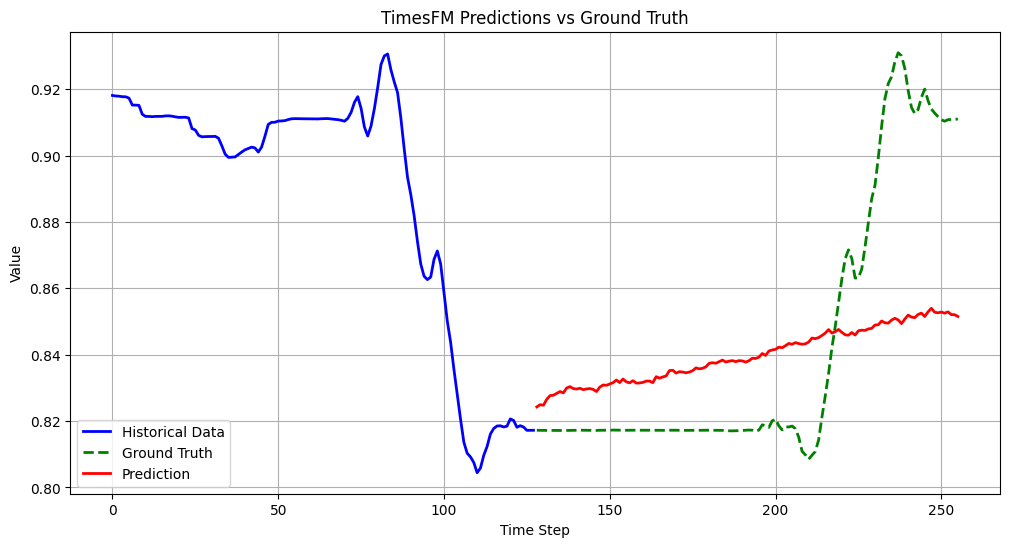

In [5]:
single_gpu_example("LAT")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(1006, 3)
Created datasets:
- Training samples: 248
- Validation samples: 247
- Using frequency type: 2

Starting finetuning...

Finetuning completed!
Training history: 5 epochs


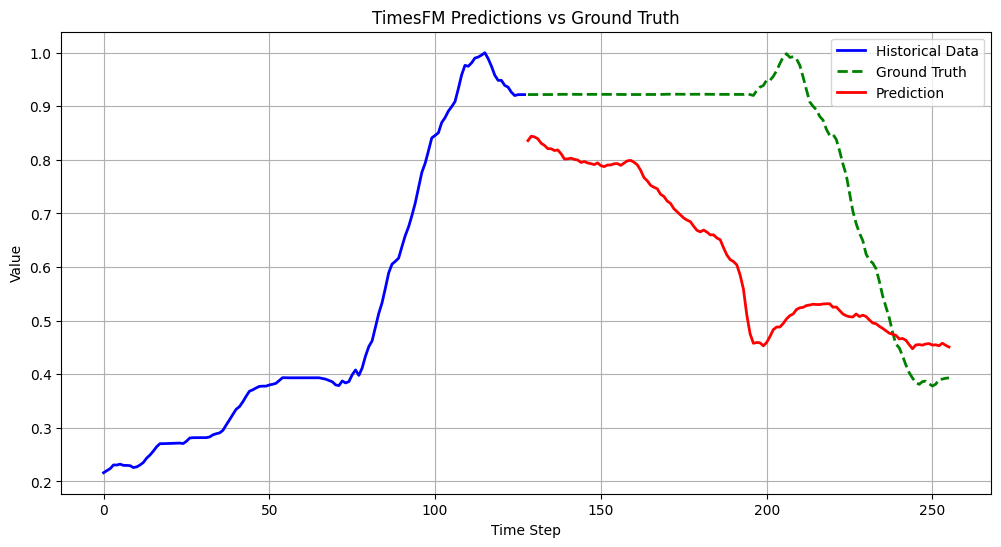

In [6]:
single_gpu_example("LON")